In [2]:
import pandas as pd
from utils.constants import Paths

## Step 1: Read and strip columns

In [2]:
user_df = pd.read_parquet(Paths.RAW_DATA_PARQUET / "user/housing_maintenance_code_complaints.parquet")

In [3]:
complaint_columns = [
    "Received Date",
    "Problem Status Date",
    "Building ID",
    "Apartment",
    "Problem Status",
    "Status Description",
    "Latitude",
    "Longitude",
    "Census Tract",
]

In [4]:
user_df = user_df[complaint_columns]

## Step 2: Process metadata


In [5]:
complaints_rename_map = {
    "Received Date": "received_date",
    "Building ID": "building_id",
    "Apartment": "apartment",
    "Problem Status" : "status",
    "Status Description": "resolution_description",
    "Problem Status Date": "date_closed",
    "Latitude": "latitude",
    "Longitude": "longitude",
    "Census Tract": "census_tract",
}

user_df = user_df.rename(columns=complaints_rename_map)

In [6]:
user_df = user_df.dropna(subset=["census_tract", "resolution_description", "date_closed"])


In [7]:
user_df = user_df[user_df["status"] == "CLOSE"]
user_df = user_df.drop(columns=["status"])

In [8]:
user_df["location_id"] = user_df["building_id"].astype(str) + user_df["apartment"].astype(str)

## Step 3: Cleaning

In [10]:
valid_complaint_strings = [
    "The Department of Housing Preservation and Development conducted an inspection for the following conditions and identified potential lead-based paint conditions. HPD will attempt to contact you to schedule a follow-up inspection to test the paint for lead.",
    "The Department of Housing Preservation and Development contacted an occupant of the apartment and verified that the following conditions were corrected. The complaint has been closed. If the condition still exists, please file a new complaint.",
    "The Department of Housing Preservation and Development contacted a tenant in the building and verified that the following conditions were corrected. The complaint has been closed. If the condition still exists, please file a new complaint.",
    "The Department of Housing Preservation and Development inspected the following conditions. A Section 8 Failure was issued. Both the tenant and the property owner will receive a notice in the mail regarding the details of the Failure and the resulting action by the Agency.",
    "The Department of Housing Preservation and Development inspected the following conditions. Violations were issued. However, HPD also identified potential lead-based paint conditions and will attempt to contact you to schedule a follow-up inspection to test the paint for lead. Information about specific violations is available at www.nyc.gov/hpd.",
    "The Department of Housing Preservation and Development inspected the following conditions. Violations were issued. Information about specific violations is available at www.nyc.gov/hpd",
    "The Department of Housing Preservation and Development inspected the following conditions. Violations were previously issued for these conditions. Information about specific violations is available at www.nyc.gov/hpd.",
]

In [11]:
duplicate_complaints = user_df[user_df["resolution_description"].str.startswith("More than one")]

In [12]:
valid_complaints = user_df[
    (~user_df["resolution_description"].str.startswith("More than one"))
    & (user_df["resolution_description"].isin(valid_complaint_strings))
]

In [13]:
valid_complaints["response_time"] = (valid_complaints["date_closed"] - valid_complaints["received_date"]).dt.days
valid_complaints = valid_complaints[valid_complaints["response_time"] >= 0]

/var/folders/_f/vkg_0cs10979h47nv_958bdw0000gp/T/ipykernel_81384/3381736003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_complaints["response_time"] = (valid_complaints["date_closed"] - valid_complaints["received_date"]).dt.days


In [14]:
valid_complaints = valid_complaints.sort_values(['received_date','location_id'])
duplicate_complaints = duplicate_complaints.sort_values(['received_date','location_id'])

In [15]:
valid_complaints["num_requests"] = 0

In [17]:
duplicate_complaints["seen"] = False

## Step 4: Counting duplicate complaints

The work here is offloaded to `aggregation_parallel_helper` since it seems like multithreading isnt supported in Jupyter

In [17]:
valid_complaints.to_parquet(Paths.PROCESSED_DATA_PARQUET / "valid_housing_code_post_process.parquet")
duplicate_complaints.to_parquet(Paths.PROCESSED_DATA_PARQUET / "duplicate_housing_code_post_process.parquet")

Assuming duplicates were found by helper script:

In [3]:
res_df = pd.read_parquet(Paths.PROCESSED_DATA_PARQUET / "temp.parquet")

## Step 5: Adding geographic data

In [4]:
import geopandas as gpd
from shapely.geometry import Point

In [5]:
res_df['geometry'] = res_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

In [7]:
res_gdf = gpd.GeoDataFrame(res_df, geometry='geometry', crs="EPSG:4326")

## Step 6: Adding census data

In [8]:
census_df = pd.read_parquet(Paths.PROCESSED_DATA_PARQUET / "census_data.parquet")

In [9]:
from shapely import wkt

census_df['geometry'] = census_df['geometry'].apply(wkt.loads)

In [10]:
census_gdf = gpd.GeoDataFrame(census_df, geometry='geometry', crs='EPSG:4326')

In [23]:
census_gdf = census_gdf.to_crs(epsg=32633)

census_gdf['population'] = census_gdf['population'].str.replace(',','').astype(int)

census_gdf['area'] = census_gdf['geometry'].area / 1e6  # convert from square meters to square kilometers
census_gdf['population_density'] = census_gdf['population'].astype(float) / census_gdf['area']

In [27]:
census_gdf = census_gdf.to_crs(epsg=4326)

In [40]:
results_census_gdf = gpd.sjoin(res_gdf, census_gdf, how="inner", op='within')

/Users/DonGuest/Code/simcity-smart-cities/simcity_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [43]:
cols = [
    "received_date",
    "date_closed",
    "num_requests",
    "response_time",
    "census_tract",
    "borough",
    "neighborhood",
    "population_density",
    "geo_id",
    "median_age",
    "hispanic_pct",
    "white_nh_pct",
    "black_nh_pct",
    "asian_nh_pct",
    "other_nh_pct",
    "two_plus_nh_pct",
    "average_hh_size",
    "less_than_hs_pct",
    "hs_pct",
    "some_college_pct",
    "associate_degree_pct",
    "bachelors_or_higher_pct",
    "median_household_income",
    "median_income_black",
    "median_income_native",
    "median_income_asian",
    "median_income_pacific_islander",
    "median_income_other",
    "median_income_two_plus",
    "median_income_white",
    "median_income_hispanic",
]

In [44]:
results_census_gdf = results_census_gdf[cols]

In [45]:
results_census_gdf.to_parquet(Paths.PROCESSED_DATA_PARQUET / "aggregated_housing_code.parquet")
results_census_gdf.to_csv(Paths.PROCESSED_DATA_CSV / "aggregated_housing_code.csv", index=False)

## Step 7: Visualization

In [46]:
import matplotlib.colors as colors
from tabulate import tabulate
import numpy as np

import contextily as ctx
import matplotlib.pyplot as plt

In [47]:
hexbin_plot_gdf = res_gdf.to_crs(epsg=3857)
vmin, vmax = np.percentile(hexbin_plot_gdf['response_time'], [5, 95])
norm = colors.Normalize(vmin=vmin, vmax=vmax)

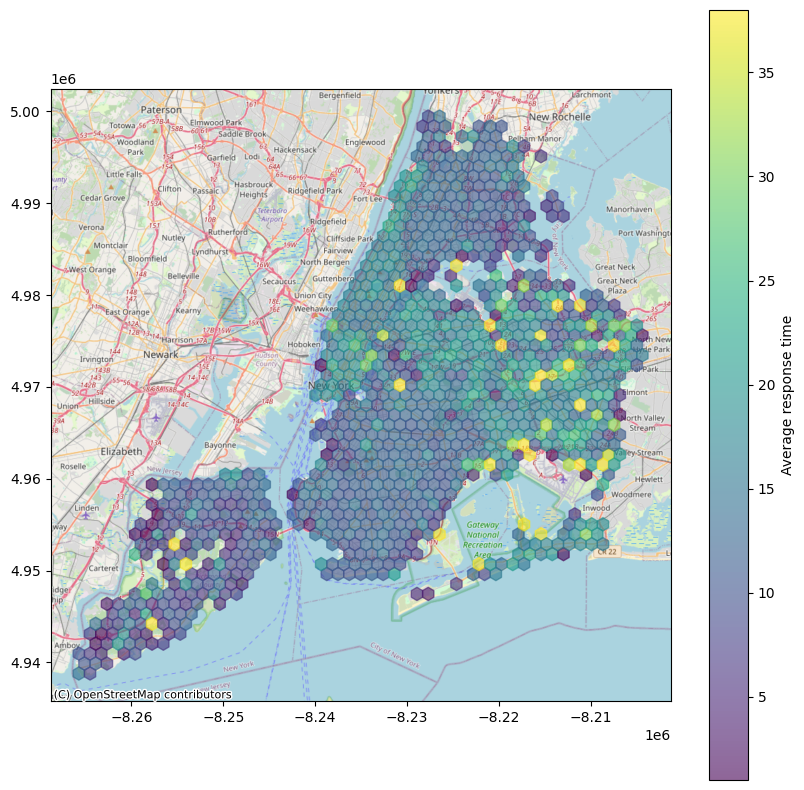

In [48]:
tile_provider = ctx.providers.OpenStreetMap.Mapnik

fig, ax = plt.subplots(figsize=(10, 10))


x = hexbin_plot_gdf.geometry.x
y = hexbin_plot_gdf.geometry.y

hb = ax.hexbin(x, y, C=hexbin_plot_gdf['response_time'], gridsize=50, reduce_C_function=np.mean, cmap='viridis', alpha=0.6, norm=norm)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Average response time')

# Add the basemap
ctx.add_basemap(ax, crs=hexbin_plot_gdf.crs.to_string(), source=tile_provider)

plt.show()

In [50]:
results_census_gdf

,received_date,date_closed,num_requests,response_time,census_tract,borough,neighborhood,population_density,geo_id,median_age,...,bachelors_or_higher_pct,median_household_income,median_income_black,median_income_native,median_income_asian,median_income_pacific_islander,median_income_other,median_income_two_plus,median_income_white,median_income_hispanic
0,2010-01-01 05:00:00,2010-01-04 05:00:00,0,3,33201,Bronx,Allerton,15539.090060,36005033201,39.7,...,31.7,37898.0,68036.0,NaN,NaN,NaN,34641.0,90931.0,26636.0,54886.0
1,2010-01-01 05:00:00,2010-01-04 05:00:00,0,3,33201,Bronx,Allerton,15539.090060,36005033201,39.7,...,31.7,37898.0,68036.0,NaN,NaN,NaN,34641.0,90931.0,26636.0,54886.0
2,2010-01-03 05:00:00,2010-02-05 05:00:00,0,33,33201,Bronx,Allerton,15539.090060,36005033201,39.7,...,31.7,37898.0,68036.0,NaN,NaN,NaN,34641.0,90931.0,26636.0,54886.0
3,2010-01-03 05:00:00,2010-02-05 05:00:00,0,33,33201,Bronx,Allerton,15539.090060,36005033201,39.7,...,31.7,37898.0,68036.0,NaN,NaN,NaN,34641.0,90931.0,26636.0,54886.0
4,2010-01-10 05:00:00,2010-03-09 05:00:00,0,58,33201,Bronx,Allerton,15539.090060,36005033201,39.7,...,31.7,37898.0,68036.0,NaN,NaN,NaN,34641.0,90931.0,26636.0,54886.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2023-07-06 04:00:00,2023-07-07 04:00:00,0,1,407,Brooklyn,The Evergreens Cemetery,4.945681,36047040700,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-07-06 04:00:00,2023-07-07 04:00:00,0,1,407,Brooklyn,The Evergreens Cemetery,4.945681,36047040700,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2023-09-17 04:00:00,2023-09-20 04:00:00,0,3,19903,Queens,Sunnyside,0.000000,36081019903,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-09-17 04:00:00,2023-09-20 04:00:00,0,3,19903,Queens,Sunnyside,0.000000,36081019903,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
print(tabulate(results_census_gdf.sort_values(by="num_requests",ascending=False).head(15), headers='keys', tablefmt="psql", showindex=False))

+---------------------+---------------------+----------------+-----------------+----------------+---------------+----------------------------------+----------------------+-------------+--------------+----------------+----------------+----------------+----------------+----------------+-------------------+-------------------+--------------------+----------+--------------------+------------------------+---------------------------+---------------------------+-----------------------+------------------------+-----------------------+----------------------------------+-----------------------+--------------------------+-----------------------+--------------------------+
| received_date       | date_closed         |   num_requests |   response_time |   census_tract | borough       | neighborhood                     |   population_density |      geo_id |   median_age |   hispanic_pct |   white_nh_pct |   black_nh_pct |   asian_nh_pct |   other_nh_pct |   two_plus_nh_pct |   average_hh_size |   le